# Benchmarking common operations

## Helper class

This class will do the benchmark and summarizing visualization.

In [2]:
import timeit
import datetime
import textwrap
import dataclasses

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, NullFormatter

from tabulate import tabulate
from tqdm.auto import tqdm

In [3]:
sns.set_context('talk')

In [4]:
@dataclasses.dataclass
class BenchmarkResult:
    name: str
    execution_time: float  # [s]
    parameter: float


class Benchmaker:
    """Light version of https://github.com/nschloe/perfplot."""

    def __init__(
        self,
        setup,
        snippets,
        parameter_range=10 ** np.arange(2, 7),
        parameter_name='Array size',
    ):
        self.setup = setup
        self.snippets = snippets

        self.parameter_range = parameter_range
        self.parameter_name = parameter_name

        self.results = []

    def _benchmark(self, code, setup, repeat_number, exec_number):
        """Return minimal execution time in seconds."""
        timer = timeit.Timer(stmt=code, setup=setup)
        exec_number = exec_number or timer.autorange()[0]

        res = timer.repeat(repeat=repeat_number, number=exec_number)
        perf = min(res)

        return perf

    def run(self, repeat_number=5, exec_number=None):
        """Run benchmark for each snippet for all parameters."""
        if self.results:
            raise RuntimeError('This benchmark has already been executed.')

        for name, code in tqdm(self.snippets, desc='Snippets'):
            for parameter in tqdm(self.parameter_range, desc='Parameters', leave=False):
                code_fmt = textwrap.dedent(code.format(parameter=parameter))
                setup_fmt = textwrap.dedent(self.setup.format(parameter=parameter))

                perf = self._benchmark(
                    code_fmt,
                    setup_fmt,
                    repeat_number=repeat_number,
                    exec_number=exec_number,
                )
                self.results.append(BenchmarkResult(name, perf, parameter))

    def print_results(self):
        """Format results as table."""
        table = tabulate(
            [dataclasses.astuple(b) for b in self.results],
            headers=['Name', 'Execution Time [s]', 'Parameter'],
        )
        print(table)

    def visualize(self):
        """Create plot summary."""
        # prepare data
        df = pd.DataFrame([dataclasses.asdict(b) for b in self.results])

        # plot
        fig, ax = plt.subplots(figsize=(8, 6))

        sns.lineplot(data=df, x='parameter', y='execution_time', hue='name', marker='o')

        ax.set_xlabel(f'Parameter: {self.parameter_name}')
        ax.set_ylabel('Execution time [h:mm:ss]')

        ax.set_xscale('log')
        ax.set_yscale('log')

        @FuncFormatter
        def time_formatter(x, pos):
            str_ = str(datetime.timedelta(seconds=x))
            return str_.rstrip('0') if '.' in str_ else str_

        ax.yaxis.set_minor_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(time_formatter)

        fig.tight_layout()

### Simple example

In [5]:
setup = 'import time'

snippets = [
    ('short sleep', 'time.sleep({parameter})'),
    ('long sleep', 'time.sleep({parameter} * 2)'),
]

In [6]:
bench = Benchmaker(
    setup, snippets, parameter_range=[1, 2, 3], parameter_name='Sleep time [s]'
)

bench.run(repeat_number=1, exec_number=1)
bench.print_results()


Name           Execution Time [s]    Parameter
-----------  --------------------  -----------
short sleep               1.00105            1
short sleep               2.00206            2
short sleep               3.00082            3
long sleep                2.00207            1
long sleep                4.00406            2
long sleep                6.00607            3


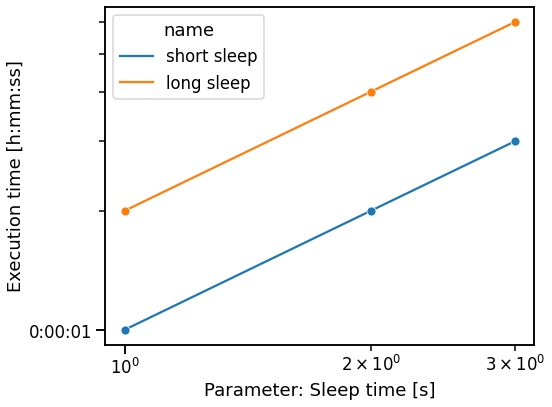

In [7]:
bench.visualize()

## Benchmarks

### Assembling a dataframe

In [8]:
setup = """
    import pandas as pd
"""

snippets = [
    (
        'pd.append',
        """
            df = pd.DataFrame()
            for i in range({parameter}):
                df = df.append(pd.DataFrame({{'i': [i]}}))
        """,
    ),
    (
        'pd.concat',
        """
            df_list = []
            for i in range({parameter}):
                df_list.append(pd.DataFrame({{'i': [i]}}))
            df = pd.concat(df_list)
        """,
    ),
    (
        'tuple-list',
        """
            tuple_list = []
            for i in range({parameter}):
                tuple_list.append((i,))
            df = pd.DataFrame(tuple_list, columns=['i'])
        """,
    ),
    (
        'dict-list',
        """
            dict_list = []
            for i in range({parameter}):
                dict_list.append({{
                    'i': i
                }})
            df = pd.DataFrame(dict_list)
        """,
    ),
]

bench = Benchmaker(setup, snippets)

In [9]:
bench.run(repeat_number=1, exec_number=1)

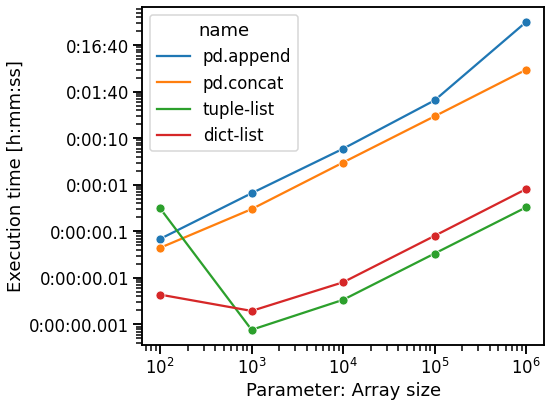

In [10]:
bench.visualize()

### Iterating over dataframe

In [11]:
setup = """
    import numpy as np
    import pandas as pd
    import swifter

    df = pd.DataFrame(np.random.normal(size=({parameter}, 10)))

    def work(x):
        return x[0] ** 2 + x[9]
"""

snippets = [
    (
        'iterrows',
        """
            for _, row in df.iterrows():
                work(row)
        """,
    ),
    (
        'itertuples',
        """
            for row in df.itertuples():
                work(row)
        """,
    ),
    (
        'apply',
        """
            df.apply(work, axis=1)
        """,
    ),
    (
        'swifter',
        """
            df.swifter.progress_bar(False).apply(work, axis=1)
        """,
    ),
]

bench = Benchmaker(setup, snippets)

In [12]:
bench.run(repeat_number=1, exec_number=1)

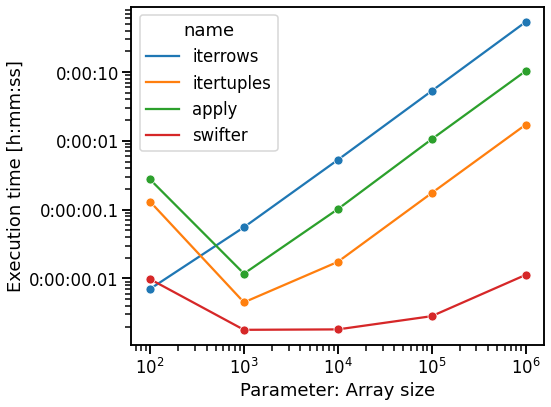

In [13]:
bench.visualize()

### Setting values to NA

In [14]:
setup = """
    import numpy as np
    import pandas as pd

    df = pd.DataFrame(np.random.randint(5, 15, size=({parameter}, {parameter})))
"""

snippets = [
    (
        'indexing',
        """
            df[df == 10] = pd.NA
        """,
    ),
    (
        'replace',
        """
            df.replace(10, pd.NA, inplace=True)
        """,
    ),
]

bench = Benchmaker(setup, snippets, parameter_range=10 ** np.arange(2, 5))

In [15]:
bench.run(repeat_number=1, exec_number=1)

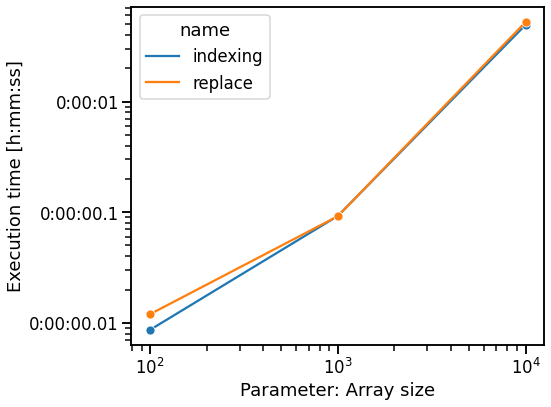

In [16]:
bench.visualize()